In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 3887 files belonging to 6 classes.
Found 693 files belonging to 6 classes.
Using 346 files for validation.
Epoch 1/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 42s 218ms/step - accuracy: 0.2157 - loss: 2.2858 - val_accuracy: 0.6069 - val_loss: 1.1992
Epoch 2/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.3733 - loss: 1.5093 - val_accuracy: 0.6127 - val_loss: 1.1166
Epoch 3/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.3825 - loss: 1.4127 - val_accuracy: 0.6561 - val_loss: 1.0566
Epoch 4/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.4036 - loss: 1.3570 - val_accuracy: 0.6705 - val_loss: 0.9818
Epoch 5/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.4391 - loss: 1.2853 - val_accuracy: 0.6705 - val_loss: 0.9182
Epoch 6/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.4707 - loss: 1.2112 - val_accuracy: 0.6676 - val_loss: 0.8417
Epoch 7/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.4908 - loss: 1.1660 - val_accura

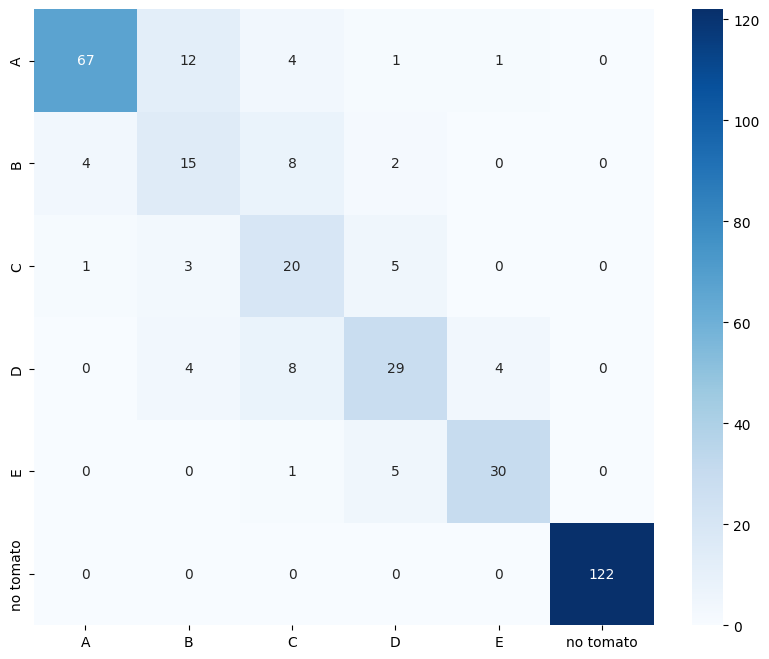

In [ ]:
#Importing libraries
import tensorflow as tf
from tensorflow import keras
from keras import losses, optimizers, layers
from keras.preprocessing import image_dataset_from_directory
from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

#Configuration: batch size and target image dimensions
BATCH = 32
SIZE = (224, 224)

#Paths of training and validation folders on Google Drive
train_dir = "/content/drive/MyDrive/data/Training_set"
val_dir = "/content/drive/MyDrive/data/Testing_set"

#Load the training dataset from directory
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,             # shuffle data each epoch
    seed=123,                 # for reproducibility
    labels="inferred",        # infer labels from subfolder names
    label_mode="categorical", # one-hot encode labels
    batch_size=BATCH,
    image_size=SIZE
)

#Load the validation dataset (50% split of Testing_set)
val_dataset = image_dataset_from_directory(
    val_dir,
    shuffle=True,
    seed=123,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.5,     # take half the data for validation
    subset="validation",      # specify that we want the validation portion
    batch_size=BATCH,
    image_size=SIZE
)

# Get the number of classes
num_classes = len(train_dataset.class_names)

#Preprocessing function
def preprocess(dataset):
    return dataset.map(lambda x, y: (preprocess_input(x), y))

#Build the model: MobileNetV3 backbone + custom dense layers on top
pre_model = MobileNetV3Large(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

pre_model.trainable = False

## Add our own classification head
x = pre_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation="softmax")(x)  # Use num_classes

model = keras.Model(inputs=pre_model.input, outputs=output)

# Compile the model
model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False),
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

#Train the model and tracking validation performance each epoch
history = model.fit(train_dataset, validation_data=val_dataset, epochs=40)

# Save the trained model
model.save("tomato_fruit.keras")
print("Model saved")

# Create confusion matrix
all_predictions = []
all_labels = []
for images, labels in val_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    all_predictions.extend(predicted_classes)
    all_labels.extend(true_classes)

confusion_matrix = tf.math.confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=CLASS_NAMES))

